In [1]:
%matplotlib inline

In [2]:
import requests
from bs4 import BeautifulSoup
from joblib import Parallel, delayed
from PIL import Image
from io import BytesIO
import json

In [33]:
headers = None

def get_headers():
    global headers
    
    if headers is None:
        _headers = """accept:*/*
accept-language:en-US,en;q=0.9
user-agent:Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36"""

        _headers = _headers.split('\n')
        headers = {i.split(':')[0]: ':'.join(i.split(':')[1:]) for i in _headers}

    return headers


def process_rg_bx(rg_str):
    # We need to transform rg to str in order to parallelize.
    # For some reason, joblib raises a runtime error when using bs4 object as input.
    rg = BeautifulSoup(rg_str, "html.parser")
    
    metadata = json.loads(rg.find_all('div', {"class": "rg_meta"})[0].text)
    image_link = metadata.get("tu")  # Link to small image
    title = metadata.get("pt")
    result_id = metadata.get("id")
    image_type = metadata.get("ity")
    caption = metadata.get("s")

    im = requests.get(image_link, headers=get_headers())
    image = Image.open(BytesIO(im.content))

    data = dict(
        title=title, image=image, caption=caption,
        image_link=image_link, result_id=result_id, image_type=image_type
    )
    
    return data


def search_image(query, num_pages=1):
    '''
    query: query terms
    ijn: page
    start: start item number
    '''
    batch = 100 
    
    params = dict(
        ei="wX7tWs60EpfGvwTnzrrwCg",
        yv="3",
        tbm="isch",
        q=query,
        vet="10ahUKEwiOmYSbpu7aAhUX448KHWenDq4QuT0IlQIoAQ.wX7tWs60EpfGvwTnzrrwCg.i",
        ved="0ahUKEwiOmYSbpu7aAhUX448KHWenDq4QuT0IlQIoAQ",
        ijn=0,
        start=0,
        asearch="ichunk",
        # async="_id:rg_s,_pms:s,_fmt:pc",
    )
    
    url = "https://www.google.com.ph/search"
    dataset = []
    
    for ijn in range(0, num_pages):
        start = ijn * batch
        params["ijn"] = ijn
        params["start"] = start

        response = requests.get(url, params=params, headers=get_headers())
        html_doc = response.json()[1][1]
            
        b = BeautifulSoup(html_doc, "html.parser")
        rg_bx = b.find_all("div", {"class": "rg_bx"})

        dataset.extend(Parallel(n_jobs=5)(delayed(process_rg_bx)(str(rg)) for rg in rg_bx))

    return dataset

In [92]:
%%time
dataset = search_image("cat", num_pages=10)

CPU times: user 1.36 s, sys: 370 ms, total: 1.73 s
Wall time: 1min 1s


In [93]:
len(set([i['result_id'] for i in dataset]))

794

In [58]:
print dataset[42]['caption']

Cat Meowing Nonstop? 7 Reasons Why Cats Meow


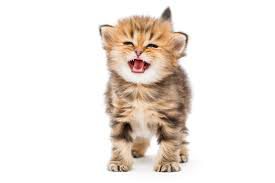

In [57]:
dataset[42]['image']

In [ ]:
# data/img/<query-words>/query-words_result-id.jpg

In [60]:
import pandas as pd

In [72]:
%%time
d = pd.DataFrame(dataset)

CPU times: user 2.39 ms, sys: 105 µs, total: 2.49 ms
Wall time: 2.07 ms


In [91]:
%%time
d.iloc[2:500]

CPU times: user 190 µs, sys: 48 µs, total: 238 µs
Wall time: 206 µs


,caption,image,image_link,image_type,result_id,title
2,,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,hMjxy8pUhhc4QM:,cat - Wiktionary
3,This Cat Is Taking Over The Internet With His ...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,R_RzGB4kWjBx-M:,This Cat Is Taking Over The Internet With His ...
4,Cat and kitten flea treatment advice | How to ...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,Vx5sPhwu_EDaTM:,Cat and kitten flea treatment advice | How to ...
5,One ...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,DJ4rSgbmWwl7OM:,Cat lifespan - The life expectancy of cats | P...
6,They Keep Themselves (and Sometimes Their Owne...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,-tl1KDanEDKoZM:,15 Signs Your Cat Is Happy | petMD
7,Ginger cat,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,B3B6q7ZifCm2kM:,Cats Protection - UK's Largest Feline Welfare ...
8,4 Ways to Cheer Up a Depressed Cat,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,UJ1IsVXYkwrf_M:,How to Cheer Up a Depressed Cat
9,All About Pixiebob Cats,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,nuOIZgbHECYBZM:,All About Pixiebob Cats - Catster
10,,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpg,GTJT8CqjTKEtwM:,Nikola Tesla's Cat and Other Feline Fascinatio...
11,Blog,<PIL.JpegImagePlugin.JpegImageFile image mode=...,https://encrypted-tbn0.gstatic.com/images?q=tb...,jpeg,5xi0KKhBZfafhM:,4 Types of Cat Cancer and Their Common Symptoms


In [89]:
%%time
dataset[2:5]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 5.96 µs


[{'caption': u'',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x224 at 0x7F693BA2AC90>,
  'image_link': u'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSZCGyzQCpBWIboSErgUWkpGjp6NnHDRHNukRLST7JZ484gOrrN',
  'image_type': u'jpg',
  'result_id': u'hMjxy8pUhhc4QM:',
  'title': u'cat - Wiktionary'},
 {'caption': u'This Cat Is Taking Over The Internet With His Hilarious Facial Expressions  Despite His Problem',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=310x163 at 0x7F693BB65810>,
  'image_link': u'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSI4qcLZn7twUkIT05kOZJ7RDUt1T-xX8g0f9szry-9A6yc4fdwCw',
  'image_type': u'jpg',
  'result_id': u'R_RzGB4kWjBx-M:',
  'title': u'This Cat Is Taking Over The Internet With His Hilarious Facial ...'},
 {'caption': u'Cat and kitten flea treatment advice | How to get rid of cat fleas | Kitten  flea treatment advice | Blue Cross',
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=

In [ ]:
d